### I would like to use ITEM-Collective Filtering to develop the recommend system.
### Because:
<li>The dataset of Last.fm mainly focus on interactions between user and artist, but few on their attributes or info.</li>
<li>For a music platform, increasing speed of new user will be much larger than new artist. Using ItemCF will give a much more stable results, and can also handle user's cold start problem</li>
<li>Easy to implement and has high interpretability</li>

# Load Dataset

In [1]:
import pandas as pd
import numpy as np

from IPython.display import Image

C:\Users\jin\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\jin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Profile

In [2]:
df_profile = pd.read_csv ("lastfm-dataset-360K\\usersha1-profile.tsv", sep = '\t', header=None)
df_profile.columns = ['user-mboxsha1','gender', 'age', 'country', 'signup']
df_profile = df_profile.rename(columns={"user-mboxsha1": "user_id", })
df_profile = df_profile[df_profile['gender']=='f']  # Only keep female users
df_profile = df_profile[['user_id']]

#### Pick top 10000 artists to speed up the development

In [3]:
df_profile = df_profile.head(20000)

## Intercation

In [4]:
df_interaction = pd.read_csv ("lastfm-dataset-360K\\usersha1-artmbid-artname-plays.tsv", sep = '\t', header=None)
df_interaction.columns = ['user-mboxsha1','musicbrainz-artist-id','artist-name','plays']
df_interaction = df_interaction.rename(columns={"user-mboxsha1": "user_id", "musicbrainz-artist-id": "artist_id"})
df_interaction = df_interaction.dropna() # drop rows with nan value

In [5]:
df_artists = df_interaction[['artist_id','artist-name']]
df_artists =df_artists.drop_duplicates()

#### Pick top 500 artists to speed up the development

In [6]:
df_artists_sub = df_artists.head(500)

In [7]:
artists_id_dict = dict(zip(df_artists_sub['artist-name'], df_artists_sub['artist_id']))
id_artists_dict = dict(zip(df_artists_sub['artist_id'], df_artists_sub['artist-name']))

In [8]:
df_user_click = df_interaction.merge(df_profile, on='user_id',how='inner')
df_user_click = df_user_click.merge(df_artists_sub, on=['artist_id','artist-name'], how='inner')

In [9]:
df_user_click.head()

,user_id,artist_id,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3


#### Get min & max count of music play for every user

In [10]:
df_user_gp =  df_user_click.groupby('user_id').agg(min_plays=('plays', 'min'), max_plays=('plays', 'max')).reset_index()

In [11]:
df_user_click_agg = df_user_click.merge(df_user_gp, on='user_id', how='inner')

#### Do Min-Max Normalization for every record

In [12]:
df_user_click_agg['plays_scaled'] = (df_user_click_agg['plays'] - df_user_click_agg['min_plays'])/(df_user_click_agg['max_plays']-df_user_click_agg['min_plays']+1e-5)

In [13]:
df_user_click_agg.head()

,user_id,artist_id,artist-name,plays,min_plays,max_plays,plays_scaled
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,131,2137,1.000000
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099,131,2137,0.482552
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897,131,2137,0.381854
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717,131,2137,0.292124
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706,131,2137,0.286640


## Create Co-occurrence Dictionary

In [14]:
users = df_user_click_agg['user_id'].unique()
print('len of users:',len(users))
artists = df_user_click_agg['artist_id'].unique()
print('len of artists:',len(artists))

len of users: 19427
len of artists: 492


In [15]:
co_appear_dict={}
for i in range(len(artists)):
    df_tmp = df_user_click_agg[df_user_click_agg['artist_id']==artists[i]]
    tmp_dict = {df_tmp['user_id'].iloc[j]: df_tmp['plays_scaled'].iloc[j] for j in range(len(df_tmp))}
    co_appear_dict.setdefault(artists[i],tmp_dict)

## Create Similarity Matrix by Pearson correlation coefficient

In [16]:
similarity_matrix = pd.DataFrame(np.identity(len(co_appear_dict)), index=co_appear_dict.keys(), columns=co_appear_dict.keys(),)

for artist_1, user_1 in co_appear_dict.items():
    for artist_2, user_2 in co_appear_dict.items():
        if artist_1 == artist_2:
            continue
        vec1, vec2 = [], []
        for user, play_count_1 in user_1.items():
            play_count_2 = user_2.get(user, -1)
            if play_count_2 == -1:
                continue
            vec1.append(play_count_1)
            vec2.append(play_count_2)
        similarity_matrix[artist_1][artist_2] = np.corrcoef(vec1, vec2)[0][1]

C:\Users\jin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\jin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\jin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\jin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\jin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\jin\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\jin\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invali

In [17]:
similarity_matrix = similarity_matrix.fillna(1e-5) # Fill nan value

## Test Recommend function

Below is a test function for our prototype, it can be used in both user-login and visitor scenarios.
<li>When session type is visitor, the function will return most k similar artists based on the artist be listened to. </li>
<li>When session type is log-in, the function will skip the artists whom has been listened by the user to encourage user explore more.</li>

In [18]:
def get_recommend_artist(test_artist, user=None, top_k=3):
    
    test_artist_id = artists_id_dict[test_artist]
    sim_lst = similarity_matrix.loc[test_artist_id]
    sim_lst = sim_lst[sim_lst.index != test_artist_id]
    if user:
        sim_lst = sim_lst.sort_values(ascending=False).reset_index().to_numpy()
        u = 0
        for i in sim_lst:
            if user in co_appear_dict[i[0]]:
                continue
            print('you may like: ', id_artists_dict[i[0]], ', with score ',i[1])
            u +=1
            if u>=top_k:
                break            
    else:
        similar_id_topk = sim_lst.nlargest(top_k).reset_index().to_numpy()
        for idx,i in enumerate(similar_id_topk):
            print('similar artist: ', id_artists_dict[i[0]], ', score:', i[1])    

In [20]:
get_recommend_artist('betty blowtorch', user='00000c289a1829a808ac09c00daf10bc3c4e223b')

you may like:  ac/dc , with score  1.0
you may like:  placebo , with score  1.0
you may like:  pelt , with score  1e-05


#### We try to get 3 recommend artists based on "betty blowtorch", and all four of them are rock bands.

In [19]:
get_recommend_artist('betty blowtorch')

similar artist:  judas priest , score: 1.0
similar artist:  placebo , score: 1.0
similar artist:  ac/dc , score: 1.0


betty blowtorch.jpg


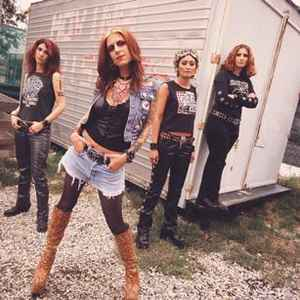

In [25]:
print('betty blowtorch.jpg')
Image(filename = "betty blowtorch.jpg", width=300, height=300)

judas priest.jpg


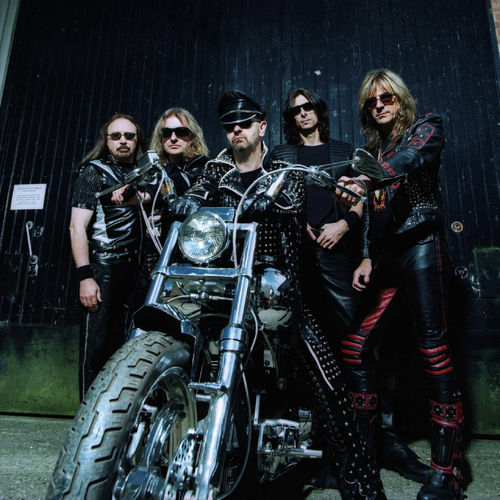

In [24]:
print('judas priest.jpg')
Image(filename = "judas priest.jpg", width=300, height=300)

placebo .jpg


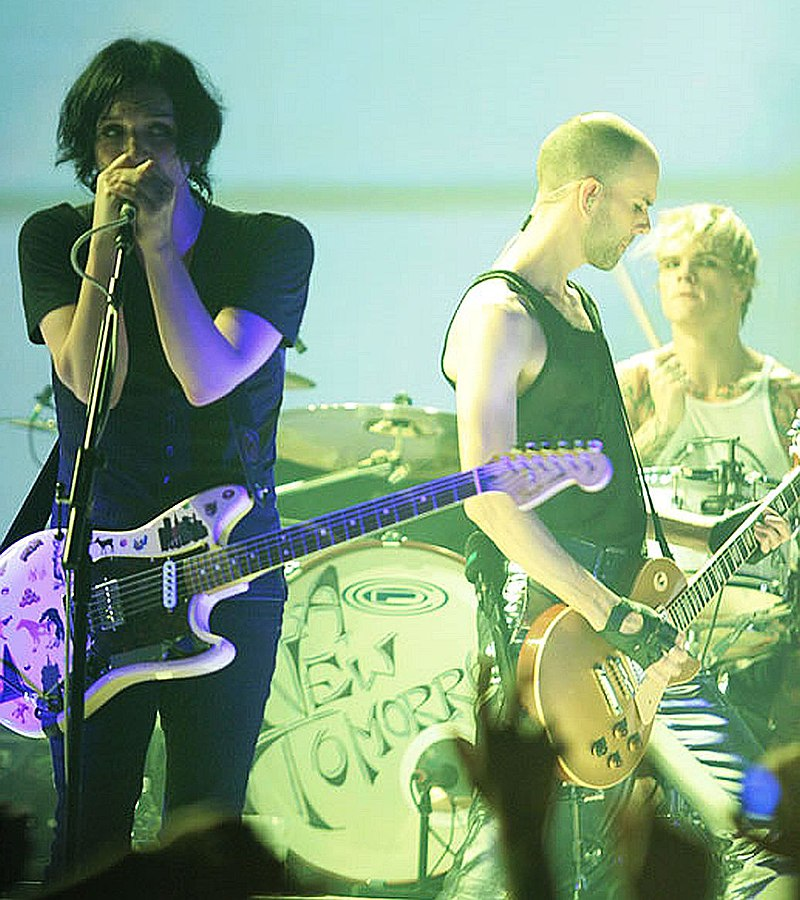

In [27]:
print('placebo .jpg')
Image(filename = "placebo .jpg", width=300, height=300)

ac_dc.jpg


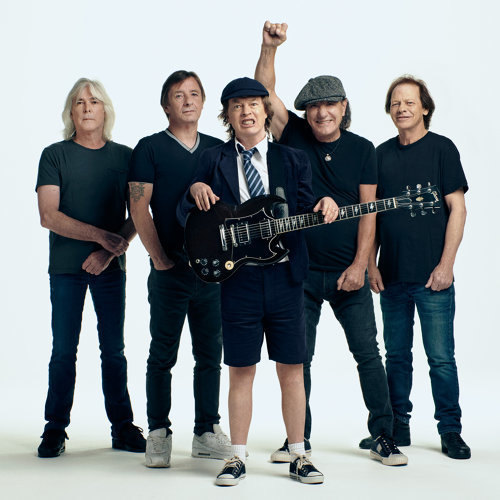

In [26]:
print('ac_dc.jpg')
Image(filename = "ac_dc.jpg", width=300, height=300)

# system design and environment setup

### For recommendation systems, it contains two parts: data part and model part.
<li>For data part, it should be able to process the real time data for model predicting and also process offline data for model re-train</li>
<li>For model part, it should be able to predict the result based on real time data, and re-train model periodically based on offline data. Perform online A/B test on different metrics(top-N CTR, Coverage etc.) and choose which model to use.</li>
<li>Model part can contains two models. The first one will generate candidates from all items, it has to be fast and simple.  The second one will sort the candidates, and it will mainly focus on accuracy. And also, you can add some domain or business logic during the process</li>

# possible concerns

<li>New artist or unpopular artist may have few chance to be recommended</li>
<li>For further improvement, the data log should contains more infomation, says like user ratings, song skip count, song play time etc. For user and artist, it should also contains more information, like artist's genre.</li>
<li>ItemCF's performance is weaker than some feature realted models, because it cannot use attributes from users and artists. May need to change the model in the future</li>
